# Big Data and Cloud Computing - Assignment #2

Group AC

- Bárbara Nóbrega Galiza - 202408654
- Carolina Nunes Valente Pires - 202408704
- Cláudia Oliveira -  202005668

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, avg, count, stddev, when, isnan
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder \
    .appName("ICU Length of Stay Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

25/05/18 19:50:46 WARN Utils: Your hostname, lenovo-barbara resolves to a loopback address: 127.0.1.1; using 10.160.7.203 instead (on interface wlan0)
25/05/18 19:50:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 19:50:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


This next chunk of code, differently from pandas, does not load the data immediatly to memory, it only builds a logical plan for the computation. However, it still take some time because it also does file discovery and infers schema from a sample (still an I/O operation).

In [12]:
start_time = time.time()

icustays = spark.read.csv("tables/ICUSTAYS.csv", header=True, inferSchema=True)
chartevents = spark.read.csv("tables/CHARTEVENTS.csv", header=True, inferSchema=True)
diagnoses = spark.read.csv('tables/DIAGNOSES_ICD.csv', header=True, inferSchema=True)
diagnosis_names = spark.read.csv('tables/D_ICD_DIAGNOSES.csv', header=True, inferSchema=True)
admissions = spark.read.csv('tables/ADMISSIONS.csv', header=True, inferSchema=True)
patients = spark.read.csv('tables/PATIENTS.csv', header=True, inferSchema=True)
items = spark.read.csv('tables/D_ITEMS.csv', header=True, inferSchema=True)


end_time = time.time()

print(f"Total CSV load time: {end_time - start_time:.2f} seconds")

Total CSV load time: 12.51 seconds


Checking if inferSchema worked:

In [ ]:
print(icustays.describe()) # LOS infered as string, requires adjusting
print(chartevents.describe())
print(diagnoses.describe())
print(diagnosis_names.describe())
print(admissions.describe())
print(patients.describe())
print(items.describe())

DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, DBSOURCE: string, FIRST_CAREUNIT: string, LAST_CAREUNIT: string, FIRST_WARDID: string, LAST_WARDID: string, LOS: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, ITEMID: string, CGID: string, VALUE: string, VALUENUM: string, VALUEUOM: string, WARNING: string, ERROR: string, RESULTSTATUS: string, STOPPED: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, SEQ_NUM: string, ICD9_CODE: string]
DataFrame[summary: string, ROW_ID: string, ICD9_CODE: string, SHORT_TITLE: string, LONG_TITLE: string]
DataFrame[summary: string, ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ADMISSION_TYPE: string, ADMISSION_LOCATION: string, DISCHARGE_LOCATION: string, INSURANCE: string, LANGUAGE: string, RELIGION: string, MARITAL_STATUS: string, ETHNICITY: string, DIAGNOSIS: string, HOSPITAL_EXPIRE_FLAG: string, H

In [9]:
d = diagnoses.filter(col("ICD9_CODE").startswith("428"))
diagnoses_disease = d.filter(col("SEQ_NUM") == 1.0)

hadm_ids = [row["HADM_ID"] for row in diagnoses_disease.select("HADM_ID").distinct().collect()]
patient_ids = [row["SUBJECT_ID"] for row in diagnoses_disease.select("SUBJECT_ID").distinct().collect()]

In the next section, we initially believed the bottleneck was the filtering, but after printing execution times, we can see counting takes much longer and it seems to be the one causing the delay. After investigating, we learned the .filter() snippet does not run the filtering when called, but only creates de DAG, that is, defines the plan of execution. Therefore, the counting takes longer because it's where the filtering DAG is executed, which involves reading chartevents big dataframe from disk, parsing the csv, applying filter and reducing to final count.

In [ ]:
start_time = time.time()
chartevents_filtered = chartevents.filter(col("HADM_ID").isin(hadm_ids))
end_time = time.time()

print(f"Total 'filtering' time: {end_time - start_time:.2f} seconds")

start_time = time.time()
print("Total number of chartevents for heart failure:", chartevents_filtered.count())
end_time = time.time()
print(f"Total counting time: {end_time - start_time:.2f} seconds")

chartevents_filtered.show(5)

Total filtering time: 1.23 seconds


Total number of chartevents for heart failure: 986502
Total counting time: 6.79 seconds
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| 27124|       165| 170252|    247247|223761|2170-10-03 18:00:00|2170-10-03 18:43:00|16187| 97.3|    97.3|      ?F|      0|    0|        NULL|   NULL|
| 27125|       165| 170252|    247247|225664|2170-10-03 18:00:00|2170-10-03 18:43:00|20277|  174|   174.0|    NULL|      0|    0|        NULL|   NULL|
| 27126|       165| 170252|    247247|220277|2170-10-03 18:35:00|2170-10-03 18:43:00|16187|   99|    99.0|       %|      0|    0|        NULL|   NULL|
| 2712

## Data preprocessing 

In [19]:
patients_filtered = patients.filter(col("SUBJECT_ID").isin(patient_ids))
admissions_filtered = admissions.filter(col("HADM_ID").isin(hadm_ids))
icustays_filtered = icustays.filter(col("HADM_ID").isin(hadm_ids))

items.show(5)

+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ROW_ID|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   457|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   458|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   459|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   460|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   461|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showi

In [20]:
print("Número de linhas em icustays:", icustays_filtered.count())
print("Número de linhas em admissions:", admissions_filtered.count())
print("Número de linhas em patients:", patients_filtered.count())

Número de linhas em icustays: 1623
Número de linhas em admissions: 1488
Número de linhas em patients: 1268


comorbities

In [21]:
from pyspark.sql.functions import col, collect_list, udf
from pyspark.sql.types import ArrayType, StringType, IntegerType

diag_filtered = diagnoses.filter(
    (col("HADM_ID").isin(hadm_ids)) & (col("SEQ_NUM") > 1)
)

grouped = diag_filtered.groupBy("HADM_ID").agg(
    collect_list("ICD9_CODE").alias("ICD9_CODE")
)

grouped.show(5, truncate=False)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|HADM_ID|ICD9_CODE                                                                                                                                                         |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|100050 |[99811, 5990, 4241, 41401, 2875, 99791, 42731, 53081, V4501]                                                                                                      |
|100061 |[5849, 4160, 4280, 496, 25060, 3572, 4439, V4582, V1254]                                                                                                          |
|100136 |[51882, 486, 42731, 4019, 2724, 45829, E9444, 2859, 7821]                                                                     

In [22]:
from pyspark.sql.functions import col, lit, when

# Filtrar diagnósticos com SEQ_NUM == 2.0 e renomear ICD9_CODE → comorbidity1
diag_seq2 = diagnoses.filter(col("SEQ_NUM") == 2.0) \
    .select("HADM_ID", col("ICD9_CODE").alias("comorbidity1"))

# Left join com diagnoses_disease
diagnoses_disease = diagnoses_disease.join(diag_seq2, on="HADM_ID", how="left")

# Substituir nulos por 0 na comorbidity1
diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity1",
    when(col("comorbidity1").isNull(), lit("0")).otherwise(col("comorbidity1"))
)

# Repetir o mesmo para SEQ_NUM == 3.0 → comorbidity2
diag_seq3 = diagnoses.filter(col("SEQ_NUM") == 3.0) \
    .select("HADM_ID", col("ICD9_CODE").alias("comorbidity2"))

diagnoses_disease = diagnoses_disease.join(diag_seq3, on="HADM_ID", how="left")

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity2",
    when(col("comorbidity2").isNull(), lit("0")).otherwise(col("comorbidity2"))
)

# Verificar resultados
diagnoses_disease.show(15, truncate=False)


+-------+------+----------+-------+---------+------------+------------+
|HADM_ID|ROW_ID|SUBJECT_ID|SEQ_NUM|ICD9_CODE|comorbidity1|comorbidity2|
+-------+------+----------+-------+---------+------------+------------+
|185360 |2460  |199       |1      |4280     |4254        |4240        |
|153627 |5001  |414       |1      |4280     |5119        |42731       |
|135828 |2163  |176       |1      |4280     |42731       |4251        |
|186199 |5839  |495       |1      |4280     |5845        |7895        |
|174800 |4092  |351       |1      |4280     |78057       |6110        |
|136326 |7557  |654       |1      |4280     |486         |51881       |
|155866 |7546  |653       |1      |42831    |42731       |5990        |
|176764 |2154  |175       |1      |42831    |51881       |5070        |
|106158 |3775  |323       |1      |4280     |99672       |99762       |
|117029 |5078  |422       |1      |42833    |51881       |2762        |
|157083 |5792  |491       |1      |42831    |99602       |9971  

In [23]:
# Contar frequência dos códigos da comorbidity1
counts1_df = diagnoses_disease.groupBy("comorbidity1").count().orderBy(col("count").desc())

# Coletar os resultados para análise em Python (porque plot é local, não Spark)
counts1 = counts1_df.toPandas().set_index("comorbidity1")["count"]

# Calcular percentagem dos top 5
top5_total = counts1.iloc[:5].sum()
total = counts1.sum()
c1 = top5_total / total

print("Percentage of the frequency explained by the top 5 comorbidities: {:.2f} %".format(c1 * 100))


Percentage of the frequency explained by the top 5 comorbidities: 44.02 %


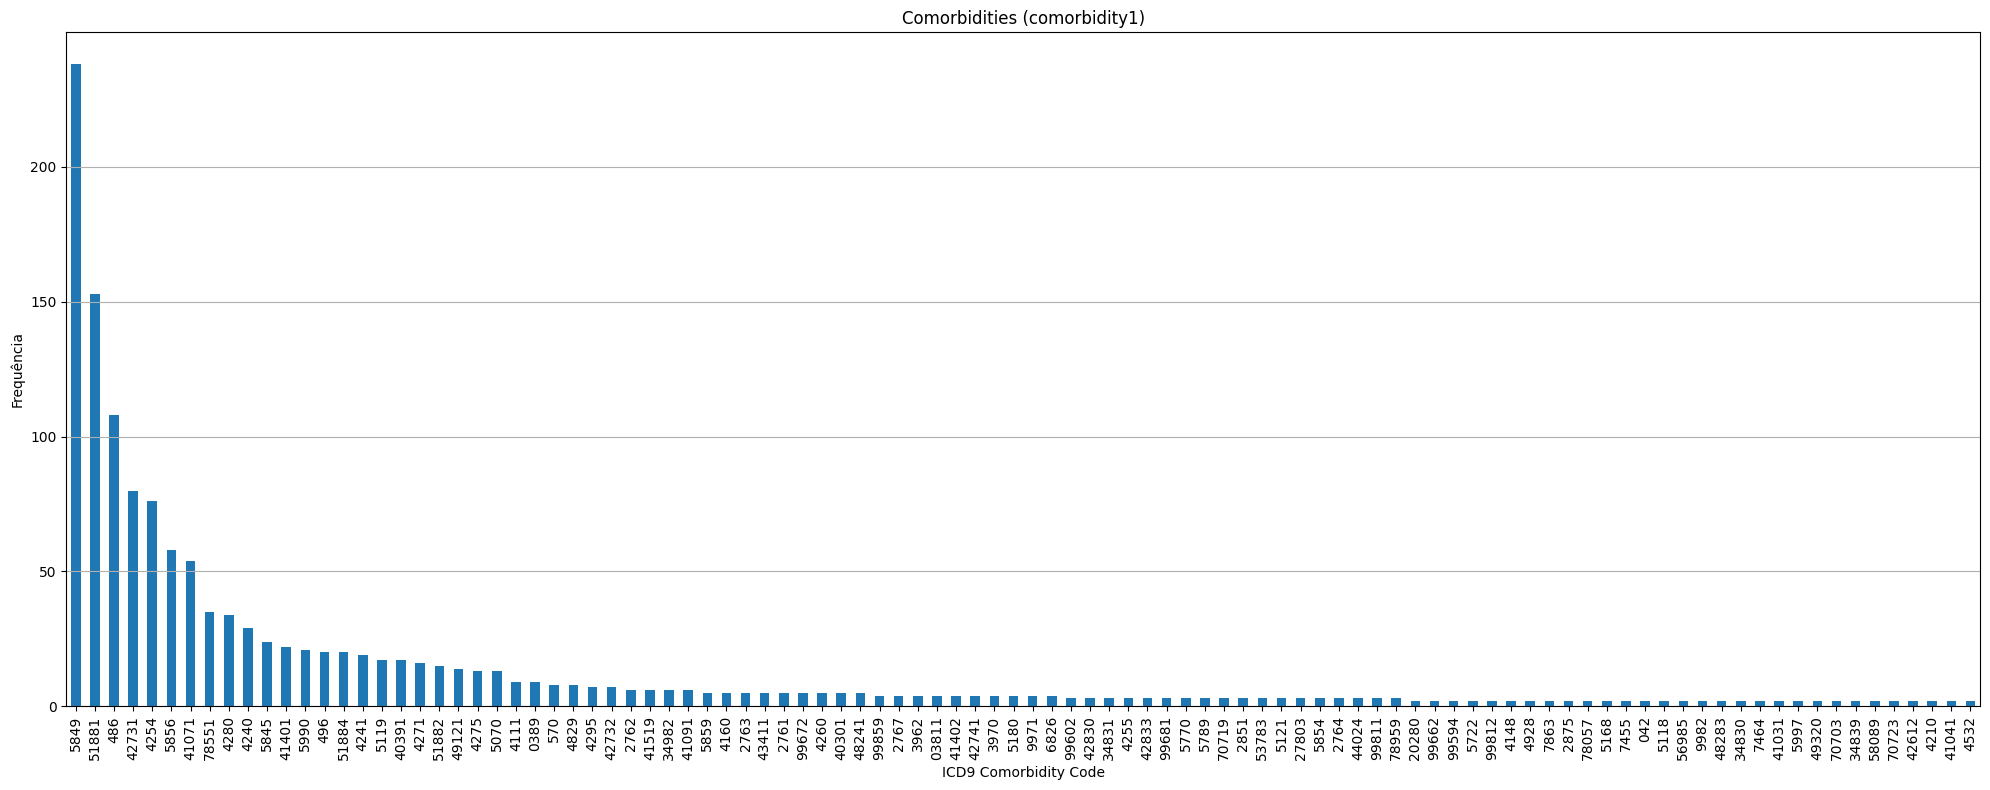

comorbidity1
5849     238
51881    153
486      108
42731     80
4254      76
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(20, 8))
counts_plot = counts1.iloc[:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('ICD9 Comorbidity Code')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(counts1.iloc[:5])


Percentage of the frequency explained by the top 5 comorbidities2: 26.48 %


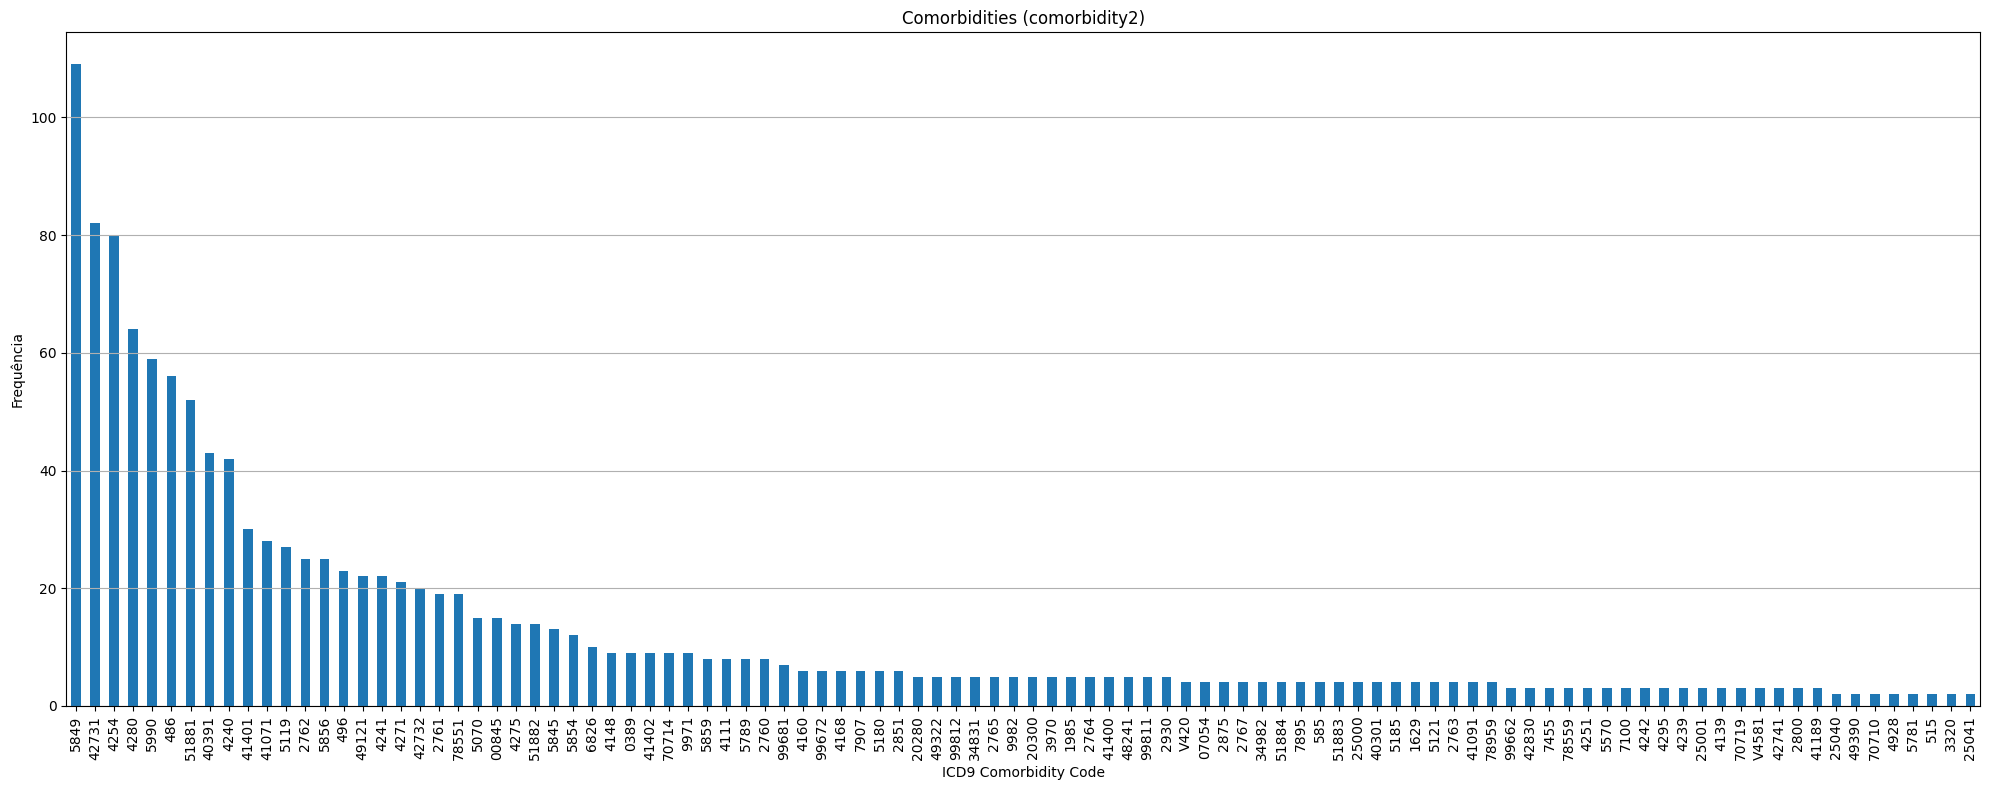

comorbidity2
5849     109
42731     82
4254      80
4280      64
5990      59
Name: count, dtype: int64


In [27]:
counts2_df = diagnoses_disease.groupBy("comorbidity2").count().orderBy(col("count").desc())

counts2 = counts2_df.toPandas().set_index("comorbidity2")["count"]

top5_total = counts2.iloc[:5].sum()
total = counts2.sum()
c2 = top5_total / total

print("Percentage of the frequency explained by the top 5 comorbidities2: {:.2f} %".format(c2 * 100))

plt.figure(figsize=(20, 8))
counts_plot = counts2.iloc[:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('ICD9 Comorbidity Code')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(counts2.iloc[:5])


## Data preparation

In [ ]:
from pyspark.sql.functions import coalesce

top5 = diagnoses_disease.groupBy("comorbidity1") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .select("comorbidity1") \
    .rdd.flatMap(lambda x: x) \
    .collect()

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity1_top5",
    when(col("comorbidity1").isin(top5), col("comorbidity1")).otherwise(lit("Other"))
)

diagnoses_disease_dummy = diagnoses_disease.select("HADM_ID", "comorbidity1_top5") \
    .withColumn("value", lit(1))  # valor binário 1

dummies = diagnoses_disease_dummy.groupBy("HADM_ID") \
    .pivot("comorbidity1_top5") \
    .agg(lit(1))

for c in dummies.columns:
    if c != "HADM_ID":
        dummies = dummies.withColumn(c, coalesce(col(c), lit(0)))

if "Other" in dummies.columns:
    dummies = dummies.drop("Other")

diagnoses_disease = diagnoses_disease.join(dummies, on="HADM_ID", how="left")


In [43]:
top5_c2 = diagnoses_disease.groupBy("comorbidity2") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5) \
    .select("comorbidity2") \
    .rdd.flatMap(lambda x: x) \
    .collect()

diagnoses_disease = diagnoses_disease.withColumn(
    "comorbidity2_top5",
    when(col("comorbidity2").isin(top5_c2), col("comorbidity2")).otherwise(lit("Other"))
)

diagnoses_disease_dummy = diagnoses_disease.select("HADM_ID", "comorbidity2_top5") \
    .withColumn("value", lit(1))

dummies2 = diagnoses_disease_dummy.groupBy("HADM_ID") \
    .pivot("comorbidity2_top5") \
    .agg(lit(1))

# Substituir nulls por 0
for c in dummies2.columns:
    if c != "HADM_ID":
        dummies2 = dummies2.withColumn(c, coalesce(col(c), lit(0)))

# Remover coluna 'Other' se presente
if "Other" in dummies2.columns:
    dummies2 = dummies2.drop("Other")

diagnoses_disease = diagnoses_disease.join(dummies2, on="HADM_ID", how="left")

for c in dummies2.columns:
    if c != "HADM_ID":
        diagnoses_disease = diagnoses_disease.withColumnRenamed(c, f"comorbidity2_{c}")


In [44]:
print("Número de linhas em diagnoses_disease:", diagnoses_disease.count())

diagnoses_disease.show(5, truncate=False)


Número de linhas em diagnoses_disease: 1488


25/05/17 13:12:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------+----------+-------+---------+------------+------------+-----------------+-----------------+------------------+---+-----+-----------------+-----+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----+-----------------+------------------+---+-----+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+
|HADM_ID|ROW_ID|SUBJECT_ID|SEQ_NUM|ICD9_CODE|comorbidity1|comorbidity2|comorbidity1_top5|comorbidity2_4254|comorbidity2_42731|486|51881|comorbidity2_5849|Other|comorbidity2_top5|comorbidity2_4254|comorbidity2_42731|comorbidity2_4280|comorbidity2_5849|comorbidity2_5990|Other|comorbidity2_4254|comorbidity2_42731|486|51881|comorbidity2_5849|comorbidity2_4254|comorbidity2_42731|comorbidity2_4280|comorbidity2_5849|comorbidity2_5990|comorbidity2_4254|comorbidity2_42731|comorbidi

In [45]:
from pyspark.sql.functions import col, unix_timestamp, when, lit

# 1. Garantir que os campos são timestamps
icustays = icustays.withColumn("INTIME", col("INTIME").cast("timestamp"))
chartevents_filtered = chartevents_filtered.withColumn("CHARTTIME", col("CHARTTIME").cast("timestamp"))

# 2. Merge com base em ICUSTAY_ID
merged = chartevents_filtered.join(
    icustays.select("ICUSTAY_ID", "INTIME"),
    on="ICUSTAY_ID",
    how="inner"
)

# 3. Calcular diferença em dias
merged = merged.withColumn(
    "DAYS_FROM_INTIME",
    (unix_timestamp("CHARTTIME") - unix_timestamp("INTIME")) / 86400
)

# 4. Corrigir valores negativos para 0
merged = merged.withColumn(
    "DAYS_FROM_INTIME",
    when(col("DAYS_FROM_INTIME") < 0, lit(0)).otherwise(col("DAYS_FROM_INTIME"))
)

# 5. Filtrar eventos nas primeiras 24 horas
chartevents_first_day = merged.filter(col("DAYS_FROM_INTIME") < 1)



In [46]:
chartevents_filtered.show(5, truncate=False)

+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME          |STORETIME          |CGID |VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|27124 |165       |170252 |247247    |223761|2170-10-03 18:00:00|2170-10-03 18:43:00|16187|97.3 |97.3    |?F      |0      |0    |NULL        |NULL   |
|27125 |165       |170252 |247247    |225664|2170-10-03 18:00:00|2170-10-03 18:43:00|20277|174  |174.0   |NULL    |0      |0    |NULL        |NULL   |
|27126 |165       |170252 |247247    |220277|2170-10-03 18:35:00|2170-10-03 18:43:00|16187|99   |99.0    |%       |0      |0    |NULL        |NULL   |
|27127 |165       |170252 |247247    |220045|2170-10-03 18:36:00|2170-10-03 18:43:00|16187|73 

In [ ]:
print("Número de registos nas primeiras 24 horas:", chartevents_first_day.count())
chartevents_first_day.show(5, truncate=False)

Número de registos nas primeiras 24 horas: 274881
+----------+------+----------+-------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+-------------------+--------------------+
|ICUSTAY_ID|ROW_ID|SUBJECT_ID|HADM_ID|ITEMID|CHARTTIME          |STORETIME          |CGID |VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|INTIME             |DAYS_FROM_INTIME    |
+----------+------+----------+-------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+-------------------+--------------------+
|247247    |27124 |165       |170252 |223761|2170-10-03 18:00:00|2170-10-03 18:43:00|16187|97.3 |97.3    |?F      |0      |0    |NULL        |NULL   |2170-10-03 17:17:53|0.029247685185185186|
|247247    |27125 |165       |170252 |225664|2170-10-03 18:00:00|2170-10-03 18:43:00|20277|174  |174.0   |NULL    |0      |0    |NULL        |NULL   |2170-10-03 17:17:53|0.0292476851

visualizations

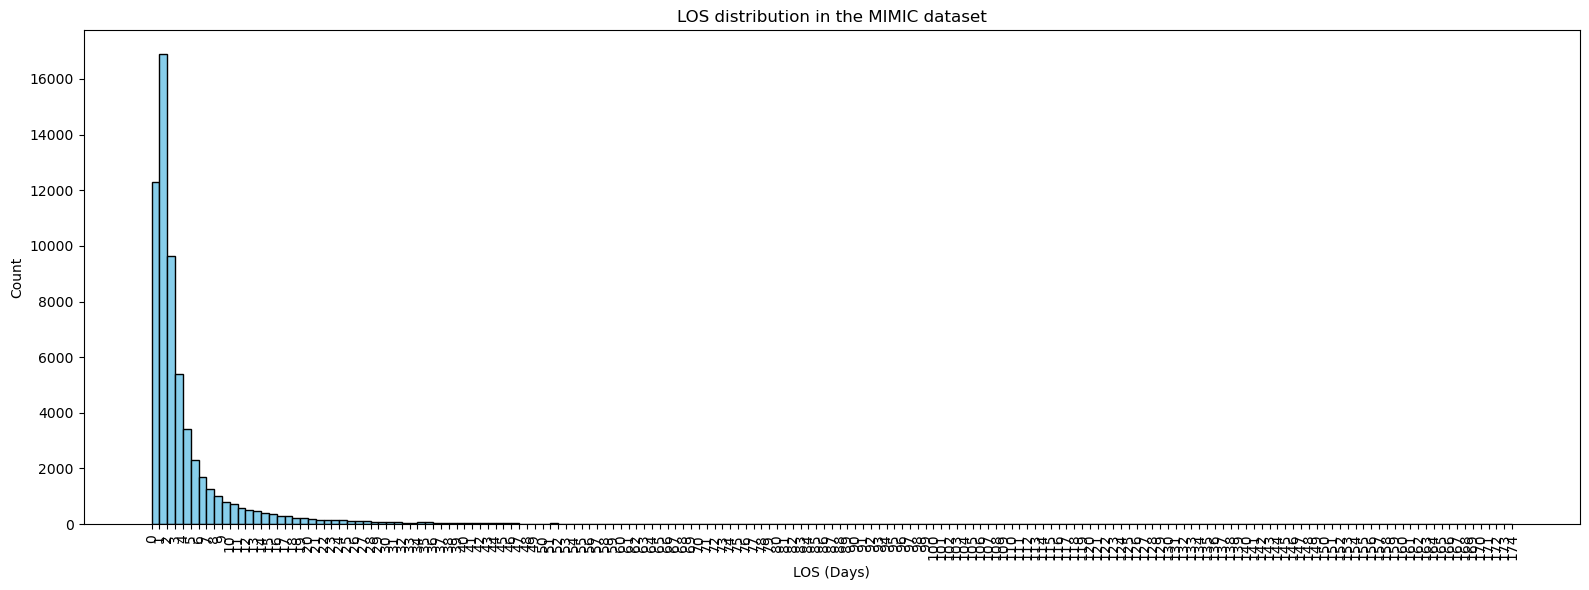

In [39]:
import numpy as np 

los_values = icustays.select("LOS").dropna().rdd.flatMap(lambda x: x).collect()

max_los = int(np.ceil(max(los_values)))

plt.figure(figsize=(16, 6))
plt.hist(los_values, bins=np.arange(0, max_los + 1, 1), edgecolor='black', color='skyblue')
plt.title("LOS distribution in the MIMIC dataset")
plt.ylabel("Count")
plt.xlabel("LOS (Days)")
plt.xticks(np.arange(0, max_los + 1, step=1), rotation=90)
plt.tight_layout()
plt.show()

In [40]:
icustays.filter(col("LOS") > 68).select("SUBJECT_ID").show(truncate=False)

+----------+
|SUBJECT_ID|
+----------+
|92        |
|93        |
|126       |
|139       |
|159       |
|621       |
|862       |
|441       |
|478       |
|517       |
|522       |
|575       |
|790       |
|1690      |
|1101      |
|1113      |
|1122      |
|1307      |
|1960      |
|2101      |
+----------+
only showing top 20 rows



-----------------------------

In [ ]:
chartevents = chartevents.filter((col("VALUENUM").isNotNull()) & (~isnan(col("VALUENUM"))))

icustays = icustays.select("ICUSTAY_ID", "SUBJECT_ID", "HADM_ID", "LOS")

In [5]:
# Filter CHARTEVENTS to first 48 hours using CHARTTIME and known INTIME window (simulado aqui com amostra)
# Supondo que já está filtrado, senão seria necessário usar a tabela ADMISSIONS/ICUSTAYS com timestamps

# Feature engineering: agregações por paciente e por tipo de item
agg_features = chartevents.groupBy("ICUSTAY_ID", "ITEMID").agg(
    avg("VALUENUM").alias("mean_value"),
    stddev("VALUENUM").alias("std_value"),
    count("VALUENUM").alias("count_value")
)


In [6]:
# Pivot para ter ITEMIDs como colunas (só para ITEMIDs mais comuns para evitar explosão dimensional)
from pyspark.sql.functions import desc

top_items = chartevents.groupBy("ITEMID").count().orderBy(desc("count")).limit(50)
top_item_ids = [row["ITEMID"] for row in top_items.collect()]

filtered_agg = agg_features.filter(col("ITEMID").isin(top_item_ids))

pivot_df = filtered_agg.groupBy("ICUSTAY_ID").pivot("ITEMID").agg(avg("mean_value"))

# Join com tabela de outcomes (LOS)
data = pivot_df.join(icustays, on="ICUSTAY_ID")


25/05/17 11:55:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
# Remove linhas com valores nulos
for c in data.columns:
    data = data.filter((col(c).isNotNull()) & (~isnan(col(c))))

print("Número de linhas após limpeza:", data.count())


# VectorAssembler para features
feature_cols = [col for col in data.columns if col not in ["ICUSTAY_ID", "SUBJECT_ID", "HADM_ID", "LOS"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="unscaled_features")
data = assembler.transform(data)



25/05/17 11:55:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Número de linhas após limpeza: 0


In [8]:
# Standardization
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withMean=True, withStd=True)
data = scaler.fit(data).transform(data)


25/05/17 11:55:42 ERROR Executor: Exception in task 0.0 in stage 36.0 (TID 195)]
java.lang.IllegalArgumentException: requirement failed: Nothing has been added to this summarizer.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.mean(Summarizer.scala:624)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.$anonfun$eval$1(Summarizer.scala:358)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.eval(Summarizer.scala:357

Py4JJavaError: An error occurred while calling o547.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 36.0 failed 1 times, most recent failure: Lost task 0.0 in stage 36.0 (TID 195) (172.20.10.3 executor driver): java.lang.IllegalArgumentException: requirement failed: Nothing has been added to this summarizer.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.mean(Summarizer.scala:624)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.$anonfun$eval$1(Summarizer.scala:358)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.eval(Summarizer.scala:357)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.eval(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.eval(interfaces.scala:594)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateResultProjection$5(AggregationIterator.scala:257)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:97)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:33)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:420)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3323)
	at org.apache.spark.sql.Dataset.first(Dataset.scala:3330)
	at org.apache.spark.ml.feature.StandardScaler.fit(StandardScaler.scala:113)
	at org.apache.spark.ml.feature.StandardScaler.fit(StandardScaler.scala:84)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.IllegalArgumentException: requirement failed: Nothing has been added to this summarizer.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.mean(Summarizer.scala:624)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.$anonfun$eval$1(Summarizer.scala:358)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.eval(Summarizer.scala:357)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.eval(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.eval(interfaces.scala:594)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateResultProjection$5(AggregationIterator.scala:257)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:97)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.next(ObjectAggregationIterator.scala:33)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


In [ ]:
# Split into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest model
train_start = time.time()
rf = RandomForestRegressor(featuresCol="features", labelCol="LOS", numTrees=50)
model = rf.fit(train_data)
train_time = time.time() - train_start

# Predict and evaluate
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Report total execution time
total_time = time.time() - total_start

print("RMSE:", rmse)
print("Training Time (s):", train_time)
print("Total Execution Time (s):", total_time)

# Stop Spark session
spark.stop()


IllegalArgumentException: features does not exist. Available: ICUSTAY_ID, 211, 220045, 220046, 220047, 220050, 220051, 220052, 220074, 220179, 220180, 220181, 220210, 220277, 220292, 220293, 220339, 220545, 220602, 220615, 220621, 220645, 223751, 223752, 223761, 223769, 223770, 223834, 223835, 223873, 223874, 223875, 223876, 224161, 224162, 224684, 224685, 224686, 224687, 224688, 224689, 224690, 224695, 224697, 224738, 225664, 226253, 226871, 226873, 227442, 227443, SUBJECT_ID, HADM_ID, LOS, unscaled_features

25/05/17 00:33:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 529215 ms exceeds timeout 120000 ms
25/05/17 00:33:32 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/17 00:33:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$